In [49]:
import os
import logging
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import tqdm

import sklearn.manifold as sm
import sklearn.decomposition as sd
import sklearn.model_selection as ms
import sklearn.preprocessing as spr
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import sklearn.metrics as sx
import sklearn.calibration as sc

import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)
%matplotlib inline
sns.set()

p = print

In [2]:
price = pd.read_csv("../data/hitbtcUSD.csv")
price.columns = ['ts', 'price', 'volume']
price = price.assign(ts=price.astype(int))\
.assign(date=pd.to_datetime(price.ts, unit='s'))
price = price.set_index('date')

In [7]:
ohlc = price.price.resample('1h').ohlc().dropna()

In [11]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [10]:
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)        
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

In [40]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


In [30]:
data = bt.feeds.PandasData(dataname=ohlc[ohlc.index>'2017-08-01'].copy())

In [46]:
cerebro = bt.Cerebro(stdstats=True)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=0.1)
cerebro.broker.setcommission(commission=0.001)
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data)

In [47]:
cerebro.run()

2017-08-02, Close, 2725.26
2017-08-02, BUY CREATE, 2725.26
2017-08-02, BUY EXECUTED, Price: 2715.00, Cost: 271.50, Comm 0.27
2017-08-02, Close, 2745.05
2017-08-02, Close, 2725.94
2017-08-02, Close, 2671.35
2017-08-02, SELL CREATE, 2671.35
2017-08-02, SELL EXECUTED, Price: 2686.80, Cost: 271.50, Comm 0.27
2017-08-02, OPERATION PROFIT, GROSS -2.82, NET -3.36
2017-08-02, Close, 2688.31
2017-08-02, Close, 2690.16
2017-08-02, Close, 2733.36
2017-08-02, BUY CREATE, 2733.36
2017-08-02, BUY EXECUTED, Price: 2734.00, Cost: 273.40, Comm 0.27
2017-08-02, Close, 2750.00
2017-08-02, Close, 2965.50
2017-08-02, Close, 2707.83
2017-08-02, SELL CREATE, 2707.83
2017-08-02, SELL EXECUTED, Price: 2707.82, Cost: 273.40, Comm 0.27
2017-08-02, OPERATION PROFIT, GROSS -2.62, NET -3.16
2017-08-02, Close, 2688.50
2017-08-02, Close, 2657.55
2017-08-02, Close, 2682.90
2017-08-02, Close, 2692.00
2017-08-03, Close, 2706.97
2017-08-03, Close, 2716.49
2017-08-03, Close, 2718.79
2017-08-03, Close, 2714.86
2017-08-03, 

2017-08-13, BUY EXECUTED, Price: 4084.78, Cost: 408.48, Comm 0.41
2017-08-13, Close, 4081.66
2017-08-13, Close, 4061.42
2017-08-14, Close, 4062.62
2017-08-14, Close, 4059.46
2017-08-14, Close, 4061.99
2017-08-14, Close, 3988.78
2017-08-14, SELL CREATE, 3988.78
2017-08-14, SELL EXECUTED, Price: 3987.02, Cost: 408.48, Comm 0.40
2017-08-14, OPERATION PROFIT, GROSS -9.78, NET -10.58
2017-08-14, Close, 4024.88
2017-08-14, Close, 4023.47
2017-08-14, Close, 4068.15
2017-08-14, BUY CREATE, 4068.15
2017-08-14, BUY EXECUTED, Price: 4059.36, Cost: 405.94, Comm 0.41
2017-08-14, Close, 4059.99
2017-08-14, Close, 4129.54
2017-08-14, Close, 4195.91
2017-08-14, Close, 4212.55
2017-08-14, Close, 4169.64
2017-08-14, Close, 4188.99
2017-08-14, Close, 4248.81
2017-08-14, Close, 4280.13
2017-08-14, Close, 4239.66
2017-08-14, Close, 4278.78
2017-08-14, Close, 4266.76
2017-08-14, Close, 4285.46
2017-08-14, Close, 4206.79
2017-08-14, Close, 4241.00
2017-08-14, Close, 4270.73
2017-08-14, Close, 4234.24
2017-08

2017-09-06, Close, 4528.88
2017-09-06, Close, 4491.10
2017-09-06, Close, 4518.97
2017-09-06, Close, 4531.71
2017-09-06, Close, 4509.14
2017-09-06, Close, 4487.87
2017-09-06, Close, 4491.28
2017-09-06, Close, 4577.58
2017-09-06, Close, 4584.55
2017-09-06, Close, 4610.51
2017-09-06, Close, 4579.46
2017-09-06, Close, 4584.96
2017-09-06, Close, 4537.80
2017-09-06, Close, 4571.87
2017-09-06, Close, 4594.93
2017-09-06, Close, 4582.64
2017-09-07, Close, 4522.77
2017-09-07, SELL CREATE, 4522.77
2017-09-07, SELL EXECUTED, Price: 4532.36, Cost: 413.13, Comm 0.45
2017-09-07, OPERATION PROFIT, GROSS 40.11, NET 39.24
2017-09-07, Close, 4479.12
2017-09-07, Close, 4511.56
2017-09-07, Close, 4500.41
2017-09-07, Close, 4526.95
2017-09-07, Close, 4536.67
2017-09-07, Close, 4507.29
2017-09-07, Close, 4480.03
2017-09-07, Close, 4528.84
2017-09-07, Close, 4574.19
2017-09-07, BUY CREATE, 4574.19
2017-09-07, BUY EXECUTED, Price: 4578.96, Cost: 457.90, Comm 0.46
2017-09-07, Close, 4575.30
2017-09-07, Close, 4

2017-09-21, BUY CREATE, 3892.29
2017-09-21, BUY EXECUTED, Price: 3891.34, Cost: 389.13, Comm 0.39
2017-09-21, Close, 3859.74
2017-09-21, SELL CREATE, 3859.74
2017-09-21, SELL EXECUTED, Price: 3861.20, Cost: 389.13, Comm 0.39
2017-09-21, OPERATION PROFIT, GROSS -3.01, NET -3.79
2017-09-21, Close, 3859.10
2017-09-21, Close, 3857.46
2017-09-21, Close, 3771.00
2017-09-21, Close, 3738.90
2017-09-21, Close, 3675.33
2017-09-21, Close, 3668.06
2017-09-21, Close, 3667.88
2017-09-21, Close, 3617.92
2017-09-21, Close, 3625.92
2017-09-21, Close, 3633.70
2017-09-21, Close, 3618.54
2017-09-21, Close, 3595.26
2017-09-22, Close, 3642.46
2017-09-22, Close, 3639.71
2017-09-22, Close, 3623.51
2017-09-22, Close, 3670.68
2017-09-22, BUY CREATE, 3670.68
2017-09-22, BUY EXECUTED, Price: 3669.93, Cost: 366.99, Comm 0.37
2017-09-22, Close, 3695.00
2017-09-22, Close, 3694.63
2017-09-22, Close, 3715.00
2017-09-22, Close, 3658.01
2017-09-22, Close, 3647.00
2017-09-22, SELL CREATE, 3647.00
2017-09-22, SELL EXECUTE

2017-10-10, Close, 4817.51
2017-10-10, BUY CREATE, 4817.51
2017-10-10, BUY EXECUTED, Price: 4819.11, Cost: 481.91, Comm 0.48
2017-10-10, Close, 4802.40
2017-10-10, SELL CREATE, 4802.40
2017-10-10, SELL EXECUTED, Price: 4799.11, Cost: 481.91, Comm 0.48
2017-10-10, OPERATION PROFIT, GROSS -2.00, NET -2.96
2017-10-10, Close, 4840.15
2017-10-10, BUY CREATE, 4840.15
2017-10-10, BUY EXECUTED, Price: 4840.84, Cost: 484.08, Comm 0.48
2017-10-10, Close, 4824.98
2017-10-10, Close, 4796.80
2017-10-10, SELL CREATE, 4796.80
2017-10-10, SELL EXECUTED, Price: 4802.66, Cost: 484.08, Comm 0.48
2017-10-10, OPERATION PROFIT, GROSS -3.82, NET -4.78
2017-10-10, Close, 4809.00
2017-10-10, Close, 4883.19
2017-10-10, BUY CREATE, 4883.19
2017-10-10, BUY EXECUTED, Price: 4880.03, Cost: 488.00, Comm 0.49
2017-10-10, Close, 4896.69
2017-10-10, Close, 4885.31
2017-10-10, Close, 4883.56
2017-10-10, Close, 4898.21
2017-10-10, Close, 4848.13
2017-10-10, Close, 4781.88
2017-10-10, SELL CREATE, 4781.88
2017-10-10, SELL

2017-10-25, Close, 5383.39
2017-10-25, Close, 5543.53
2017-10-25, Close, 5506.07
2017-10-25, Close, 5482.66
2017-10-25, Close, 5513.23
2017-10-25, Close, 5568.19
2017-10-25, BUY CREATE, 5568.19
2017-10-25, BUY EXECUTED, Price: 5566.54, Cost: 556.65, Comm 0.56
2017-10-25, Close, 5595.48
2017-10-25, Close, 5598.61
2017-10-25, Close, 5533.65
2017-10-25, Close, 5513.19
2017-10-25, Close, 5497.29
2017-10-25, SELL CREATE, 5497.29
2017-10-25, SELL EXECUTED, Price: 5499.14, Cost: 556.65, Comm 0.55
2017-10-25, OPERATION PROFIT, GROSS -6.74, NET -7.85
2017-10-25, Close, 5514.04
2017-10-25, BUY CREATE, 5514.04
2017-10-25, BUY EXECUTED, Price: 5512.39, Cost: 551.24, Comm 0.55
2017-10-25, Close, 5474.14
2017-10-25, SELL CREATE, 5474.14
2017-10-25, SELL EXECUTED, Price: 5472.22, Cost: 551.24, Comm 0.55
2017-10-25, OPERATION PROFIT, GROSS -4.02, NET -5.12
2017-10-25, Close, 5460.58
2017-10-25, Close, 5507.65
2017-10-25, Close, 5511.87
2017-10-25, Close, 5541.98
2017-10-25, BUY CREATE, 5541.98
2017-10

2017-11-04, BUY EXECUTED, Price: 7159.90, Cost: 715.99, Comm 0.72
2017-11-04, Close, 7310.00
2017-11-04, Close, 7298.35
2017-11-04, Close, 7319.66
2017-11-04, Close, 7340.65
2017-11-04, Close, 7316.11
2017-11-04, Close, 7299.78
2017-11-04, Close, 7324.56
2017-11-04, Close, 7341.49
2017-11-04, Close, 7338.72
2017-11-04, Close, 7324.23
2017-11-04, Close, 7365.94
2017-11-05, Close, 7325.59
2017-11-05, Close, 7377.48
2017-11-05, Close, 7356.10
2017-11-05, Close, 7389.37
2017-11-05, Close, 7405.41
2017-11-05, Close, 7438.54
2017-11-05, Close, 7459.92
2017-11-05, Close, 7416.79
2017-11-05, Close, 7426.78
2017-11-05, Close, 7428.00
2017-11-05, Close, 7442.53
2017-11-05, Close, 7532.05
2017-11-05, Close, 7546.17
2017-11-05, Close, 7573.13
2017-11-05, Close, 7544.37
2017-11-05, Close, 7501.02
2017-11-05, Close, 7508.87
2017-11-05, Close, 7499.61
2017-11-05, Close, 7519.45
2017-11-05, Close, 7558.76
2017-11-05, Close, 7511.85
2017-11-05, Close, 7341.75
2017-11-05, SELL CREATE, 7341.75
2017-11-05

/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


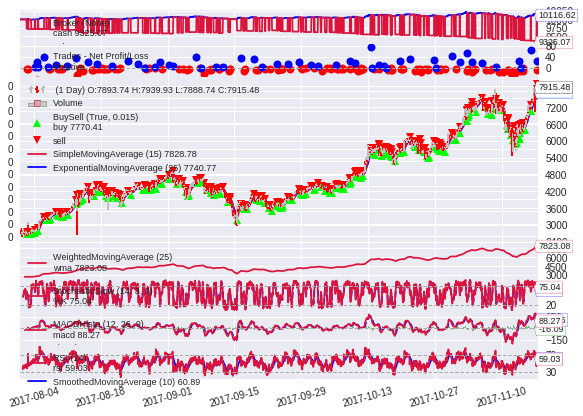

[[<matplotlib.figure.Figure at 0x7fa69a25bd68>]]

In [53]:
# Plot the result
plt.figure(figsize=(20,20))
cerebro.plot()